In [28]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Dataset is taken from Kaggle: <br>
https://www.kaggle.com/datasets/arjuntejaswi/plant-village/ <br>
We will only use 3 folders: 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy'. <br>
A tomato leaf can be healthy or unhealthy (either early blight or leaf mold). <br>
CNN is used to classify these tomato leaves accordinly.

In [29]:
image_size = 256
batch_size = 32
channels = 3  # rgb channels
epochs = 50

In [48]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (image_size, image_size),
    batch_size = batch_size
    )

Found 3543 files belonging to 3 classes.


In [49]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy']

(32, 256, 256, 3)
[2 2 0 1 2 0 2 0 1 0 2 2 2 1 2 0 1 2 0 0 2 2 2 1 0 1 2 0 2 1 0 2]


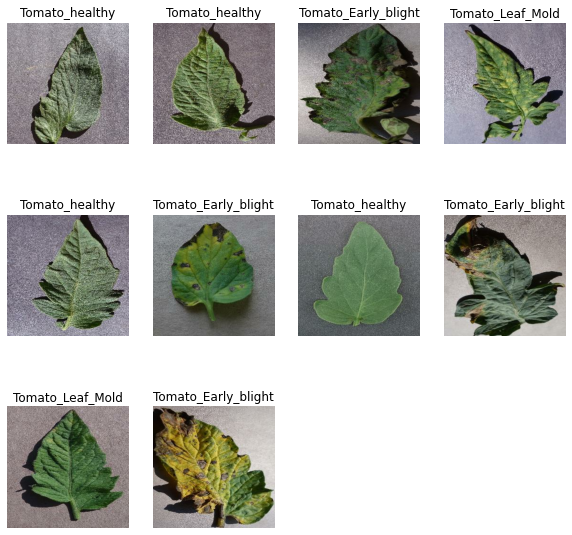

In [50]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): 
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(10):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [51]:
len(dataset)

111

In [52]:
# 80% training
# 10% validation and 10% testing
train_size = 0.8
len(dataset) * train_size

88.80000000000001

In [40]:
len(dataset.take(88))

88

In [54]:
len(dataset.skip(88))

23

In [55]:
23+88

111

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [57]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [58]:
len(train_ds)

88

In [62]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [63]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [64]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Building a Model

In [65]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [67]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### Training a model

In [69]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
88/88 [==============================] - 158s 2s/step - loss: 0.9601 - accuracy: 0.4752 - val_loss: 0.7952 - val_accuracy: 0.5341
Epoch 2/50
88/88 [==============================] - 167s 2s/step - loss: 0.6638 - accuracy: 0.6983 - val_loss: 0.4208 - val_accuracy: 0.8239
Epoch 3/50
88/88 [==============================] - 161s 2s/step - loss: 0.3598 - accuracy: 0.8571 - val_loss: 0.2216 - val_accuracy: 0.9176
Epoch 4/50
88/88 [==============================] - 164s 2s/step - loss: 0.2447 - accuracy: 0.9127 - val_loss: 0.1861 - val_accuracy: 0.9290
Epoch 5/50
88/88 [==============================] - 157s 2s/step - loss: 0.2426 - accuracy: 0.9181 - val_loss: 0.4972 - val_accuracy: 0.8182
Epoch 6/50
88/88 [==============================] - 138s 2s/step - loss: 0.2123 - accuracy: 0.9255 - val_loss: 0.0955 - val_accuracy: 0.9716
Epoch 7/50
88/88 [==============================] - 131s 1s/step - loss: 0.1504 - accuracy: 0.9491 - val_loss: 0.1874 - val_accuracy: 0.9176
Epoch 8/50
88

In [70]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 7s 316ms/step - loss: 1.6399e-05 - accuracy: 1.0000


##### Accuracy is 100% which is awesome!

In [71]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 88}

In [85]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

### Visualizing the training results

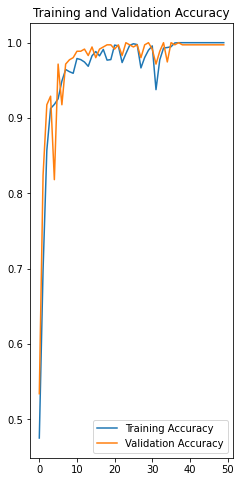

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

#### As seen from the graph, around 38 epochs were enough for the training.

first image to predict
actual label: Tomato_Leaf_Mold
1/1 [==============================] - 0s 317ms/step
predicted label: Tomato_Leaf_Mold


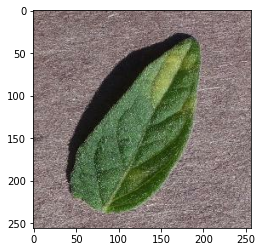

In [80]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [82]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [83]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


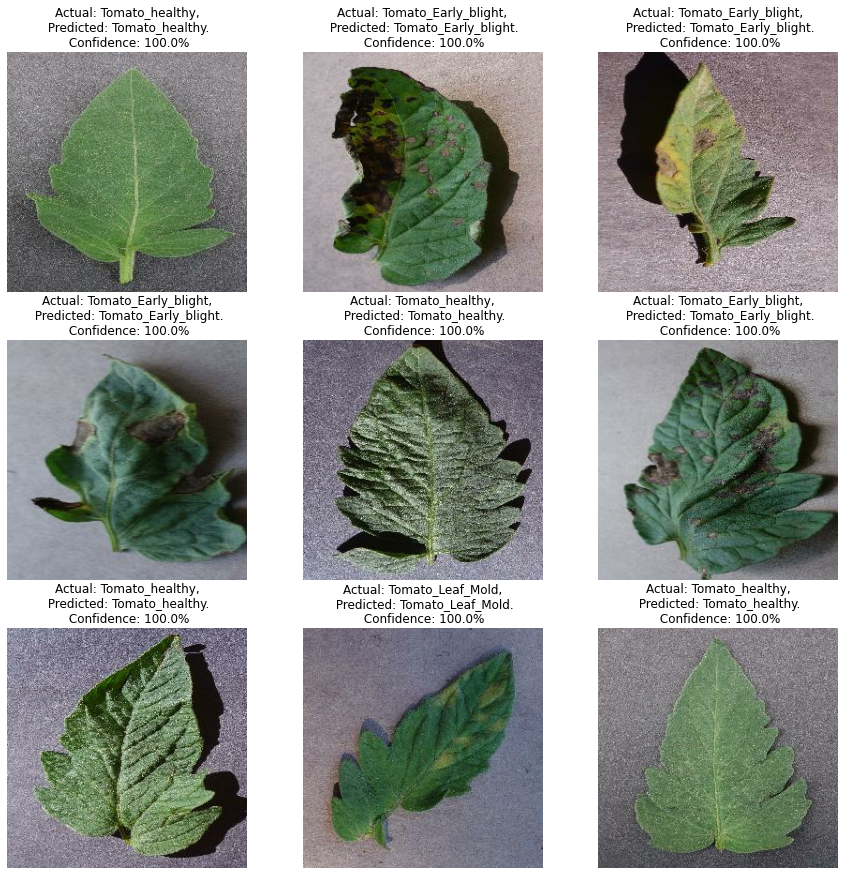

In [84]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

This model can be used by farmers to detect healthy vs unhealthy tomato leaves and use appropriate treatment for them